# Stationay SCM and DAG (STAT.) from figure 1 in paper

In [10]:
import sys
sys.path.append("../src/")
sys.path.append("..")

from src.examples.example_setups import setup_stat_scm
from src.utils.sequential_causal_functions import sequentially_sample_model
from src.utils.sem_utils.toy_sems import StationaryDependentSEM

# Models
from src.methods.bo import BO
from src.methods.cbo import CBO
from src.methods.abo import ABO
from src.methods.dcbo import DCBO


## Sample SEM to get observational samples

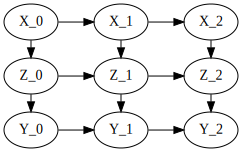

In [16]:
T = 3 # In this example, as in the paper, we consider three time-slices
init_sem, sem, dag_view, dag  = setup_stat_scm(T=3)
dag_view

The above DAG is the graphical structure we will be working with and is faithful to the one used in figure one in the paper. `dag` is a networkx object i.e.

In [17]:
type(dag)

networkx.classes.multidigraph.MultiDiGraph

and is the one we will use for exploring the optimization methods further down. `dag_view` is simply a convenient way to visualise the structure at hand and is just a string that we visulise using `pygraphviz`:

In [18]:
print(dag_view)

digraph { rankdir=LR; X_0 -> Z_0; Z_0 -> Y_0; X_1 -> Z_1; Z_1 -> Y_1; X_2 -> Z_2; Z_2 -> Y_2;  X_0 -> X_1; Z_0 -> Z_1; Y_0 -> Y_1; X_1 -> X_2; Z_1 -> Z_2; Y_1 -> Y_2;  { rank=same; X_0 Z_0 Y_0 } { rank=same; X_1 Z_1 Y_1 } { rank=same; X_2 Z_2 Y_2 }  }


Notice that we make use of two types of structural equations models: `init_sem` and `sem`. The latter concerns interactions with the first time-slice in the DBN, which has no incoming edges from the previous time-slices, and is only active at $t=0$. For all other time-slices i.e. when $t>0$ the `sem` model is used.

In [15]:
# Number of independent samples per time-index
D_Obs = sequentially_sample_model(init_sem,
                                sem,
                                total_timesteps=T,
                                sample_count=5, # How many samples we take per node in each time-slice
                                epsilon=None) # If we employ a noise model or not

D_Obs

{'X': array([[-0.56782134, -0.70287856, -0.22035261],
        [ 0.8089576 , -0.01391157, -0.96019663],
        [-1.06494067, -1.41363813, -2.56603851],
        [-0.46340272,  0.02742972,  2.43171383],
        [-0.19257217, -0.20708109, -0.35612655]]),
 'Z': array([[ 1.47034355,  3.50650397,  3.94172276],
        [ 2.0147878 ,  4.13318748,  8.46298562],
        [ 2.94324436,  5.94096229, 20.26070363],
        [ 4.72775791,  4.21166437,  2.76579469],
        [ 0.64248659,  2.23308413,  4.27395593]]),
 'Y': array([[-2.10910858, -3.30576148, -3.49202066],
        [-0.86977444, -1.45798619, -2.11556171],
        [-2.57496445, -1.05672848, -0.60518715],
        [-0.49055256, -2.76543881, -5.0358863 ],
        [ 0.10853582, -1.88867869, -3.81768144]])}

The above observation samples contained in `D_obs` are sequential in the sense that the sample function generates each column per variable, conditional on the column samples at $t-1$.

## Additional problem setup

## Explore optimization methods

In [ ]:
BO_input_params = {
    "graph": dag,
    "sem": StationaryDependentSEM,
    "observational_samples":D_Obs,
    "intervention_domain": intervention_domain,
    "interventional_samples":None,   
    "number_of_trials": 10,
    "optimal_assigned_blankets": None,
    "sample_anchor_points": True,
    "seed_anchor_points": 1,
    "change_points": None
}